In [1]:
import numpy as np
DTYPE = np.float64
# import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
import pickle
import gzip
from tqdm import tqdm
import sys
sys.path.insert(0, "../../packages")
import flory_
import math

In [2]:
# Flory Huggins Free Energy function
def floryHuggins(phi:DTYPE, chi:np.array):
    part_1 = np.sum(phi*np.log(phi))
    part_2 = 0

    for i in range(len(phi)):
        for j in range(i+1, len(phi)):
            part_2 += chi[i][j]*phi[i]*phi[j]

    return part_1 + part_2

In [3]:
# General Function for computing mergers of compartments
# Returns the concentrations of components in the merged and the unmerged compartments
# Stores them in phi_in_kmerged and phi_in_kunmerged respectively.


def mergers(concs:np.array, vols:np.array, chis, merged_compartments:list):
    # Find the unmerged compartment(s)
    expected = len(vols)*(len(vols)+1)//2
    actual = np.sum(merged_compartments)
    unmerged_compartment = expected - actual

    # print(concs)
    # print(vols)
    # print(unmerged)

    # Compute the merged volumes, stored in variable eta_merged
    # subtract -1 from the merged_compartments idxs to maintain python idxing
    eta_merged = 0
    for compartment in merged_compartments:
        eta_merged += vols[compartment-1]
    # print(eta_merged)

    # Calculating the compositions of components in the merged compartment
    # Taking a simple weighted average
    phi_1merged = (vols[merged_compartments[0]-1]*concs[0, merged_compartments[0]-1] + vols[merged_compartments[1]-1]*concs[0, merged_compartments[1]-1])/eta_merged
    phi_2merged = (vols[merged_compartments[0]-1]*concs[1, merged_compartments[0]-1] + vols[merged_compartments[1]-1]*concs[1, merged_compartments[1]-1])/eta_merged
    phi_3merged = 1 - phi_1merged - phi_2merged
    # print(phi_1merged, phi_2merged, phi_3merged)
    # print(phi_1merged + phi_2merged + phi_3merged)

    phi_in_kmerged = [phi_1merged, phi_2merged, phi_3merged]
    phi_in_kunmerged = [concs[0, unmerged_compartment-1], concs[1, unmerged_compartment-1], concs[2, unmerged_compartment-1]]
    # print(phi_in_kmerged)
    # print(phi_in_kunmerged)

    F_merged = eta_merged*floryHuggins(phi_in_kmerged, chis) + vols[unmerged_compartment-1]*floryHuggins(phi_in_kunmerged, chis)
    # print(F_merged)

    return phi_in_kunmerged, phi_in_kmerged, eta_merged, unmerged_compartment

    

In [4]:
# Global concentrations
phi_globals = [np.array([0.3, 0.3, 0.4], dtype = DTYPE),
               np.array([0.3, 0.4, 0.3], dtype = DTYPE),
               np.array([0.4, 0.3, 0.3], dtype = DTYPE)]
              #  np.array([0.1, 0.5, 0.4], dtype = DTYPE),
              #  np.array([0.4, 0.5, 0.1], dtype = DTYPE),
              #  np.array([0.4, 0.1, 0.5], dtype = DTYPE),
              # ]

Xs = np.arange(0, 10.1, 0.1)

N_STEPS = [10000, 100000, 1000000]
# Xs = [0]
# tol = DTYPE(1e-4)
# x = 3.6

In [5]:
for phi_global in tqdm(phi_globals):
    for X in Xs:
        for steps in N_STEPS:
    
            chis = np.array([[0, 3.0, 3+X], [3.0, 0.0, 3.0], [3+X, 3.0, 0.0]], dtype = DTYPE)
        
            #################################
            # Run Flory for the first time
            # To get at most n_components distinct phases
            #################################
        
            n_components = 3
            free_energy = flory_.free_energy.FloryHuggins(n_components, chis)
            interaction = free_energy.interaction
            entropy = free_energy.entropy
            ensemble = flory_.CanonicalEnsemble(n_components, phi_global)
            options = {"num_part": 32, "progress": False, "max_steps": 100000}
            
            finder = flory_.CoexistingPhasesFinder(interaction, entropy, ensemble, **options)
            phases = finder.run(progress=False)
        
            # Get the number of phases
            vols = phases.get_clusters().volumes
            concs = phases.get_clusters().fractions
            
            # Normalize volumes
            vols = vols/np.sum(vols)
            # vols, concs
        
            output_filepath = f"data/withFlory/phi_g{phi_global}/raw/X{X:.3f}/"
            output_filename = f"initial_system.pkl"
            if not os.path.exists(output_filepath):
                os.makedirs(output_filepath)
            output_file = os.path.join(output_filepath, output_filename)
            data_to_save = {
                "chis": chis,
                "phi_global": phi_global,
                "flory_phases": concs,
                "flory_vols": vols,
                "metadata": {"chis-> chi matrix", "phi_global-> system global concentrations", "flory_phases-> flory's concentration output for distinct 3 phase solution", "flory_vols-> flory's output for corresponding phase vols"}
            }
            with gzip.open(output_file, "wb") as f:
                pickle.dump(data_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)
        
            ################################
            # Now, merge Compartments
            ################################
            merged_compartments_list = [np.array([1, 2], dtype=np.int64), np.array([1, 3], dtype=np.int64), np.array([2, 3], dtype=np.int64)]
            
            for merged_compartments in (merged_compartments_list):
                if concs.shape[0] == 3: # force 3 phase, else skip                    
                    phi_in_kunmerged, phi_in_kmerged, eta_merged, unmerged_compartment = mergers(concs, vols, chis, merged_compartments)
                    # print(unmerged_compartment)
                    f_initial = eta_merged*floryHuggins(phi_in_kmerged, chis) + (1-eta_merged)*floryHuggins(phi_in_kunmerged, chis)
                    # print(f_initial)
                    
                    phi_global_ = np.array([phi_in_kmerged, phi_in_kunmerged])
                    vols_ = np.array([eta_merged, 1-eta_merged])
                    
                    options = {
                    "num_part": 2,
                    "progress": False,
                    "max_steps": steps,  # disable progress bar, allow more steps
                    }
                    
                    finder2 = flory_.CoexistingPhasesFinder(interaction, entropy, ensemble, **options)
                    # finder2.reinitialize_from_omegas(-np.log(np.transpose(phi_global_)), vols_)
                    finder2.reinitialize_from_phis(np.transpose(phi_global_), vols_)
                    phases = finder2.run(progress=False).get_clusters()
                
                    vols_m =  phases.volumes/np.sum(phases.volumes)
                    fracs_m = phases.fractions
                
                    f = []
                    for idx, _ in enumerate(vols_m):
                        f.append(vols_m[idx]*floryHuggins(fracs_m[idx], chis))
                    f_best = np.sum(f)
                    
                    output_filepath = f"data/withFlory/phi_g{phi_global}/raw/X{X:.3f}/steps{steps}/mergers/{merged_compartments}/"
                    output_filename = f"initial_and_best.pkl"
                    if not os.path.exists(output_filepath):
                        os.makedirs(output_filepath)
                    output_file = os.path.join(output_filepath, output_filename)
                    data_to_save = {
                        "merged_compartments": merged_compartments,
                        "initial_guess": [phi_in_kmerged, eta_merged],
                        "F_initial": f_initial,
                        "best_location": [fracs_m[0], vols_m[0]],
                        "F_best": f_best,
                        "metadata": {
                            "initial_guess": "stores the initial merged guesses [phi_merged, eta_merged]",
                            "F_initial": "stores the initial free energy for the guess",
                            "best_location": "stores flory's output for the local minima positions [phi_flory, eta_flory] -> takes the first row of the phi matrix and the first entry of the volume array",
                            "F_best": "stores the best free energy"
                        }
                    }
            
                    # print(data_to_save)
                    with gzip.open(output_file, "wb") as file:
                        pickle.dump(data_to_save, file, protocol=pickle.HIGHEST_PROTOCOL)

                    # with gzip.open(output_file, 'rb') as f:
                    #     loaded_data = pickle.load(f)
                    # print(loaded_data)
                    # print(f_best)
            
                    # print(f"merged compartments {merged_compartments}")
                    # print(f"p_merged {phi_in_kmerged}")
                    # print(f"eta_merged {eta_merged}")
                    # print(f"vols {vols_m}")
                    # print(f"fracs {fracs_m}")
                    # print(f"F {f_tot}")
                    # print()
                
                else:
                    print(f"Skipped for X {X}, Steps {steps}")

100%|████████████████████████████████████████████| 3/3 [05:45<00:00, 115.00s/it]


In [6]:
###################################
# Analysis
##################################
dev = []
dev_merger_12 = []
dev_merger_13 = []
dev_merger_23 = []

f_initial_12 = []
f_initial_13 = []
f_initial_23 = []

f_best_12 = []
f_best_13 = []
f_best_23 = []

for X in tqdm(Xs):
    merged_compartments_list = [np.array([1, 2], dtype=np.int64), np.array([1, 3], dtype=np.int64), np.array([2, 3], dtype=np.int64)]
    # merged_compartments_list = [np.array([1, 3], dtype=np.int64)]
    sum_initial = 0
    sum_best = 0
    
    for merger_idx, merged_compartments in enumerate(merged_compartments_list):
        input_filepath = f"data/withFlory/phi_g{phi_global}/raw/X{X:.3f}/steps{steps}/mergers/{merged_compartments}/"
        input_filename = f"initial_and_best.pkl"
        input_file = os.path.join(input_filepath, input_filename)
        
        with gzip.open(input_file, 'rb') as f:
            loaded_data = pickle.load(f)
        # print(loaded_data["merged_compartments"])

        if merger_idx == 0:
            f_best_12.append(loaded_data["F_best"])
            f_initial_12.append(loaded_data["F_initial"])
        if merger_idx == 1:
            f_best_13.append(loaded_data["F_best"])
            f_initial_13.append(loaded_data["F_initial"])
        if merger_idx == 2:
            f_best_23.append(loaded_data["F_best"])
            f_initial_23.append(loaded_data["F_initial"])
            
        sum_initial += loaded_data["F_initial"]
        sum_best += loaded_data["F_best"]
        # f_in.append(loaded_data["F_initial"])
        # f_best.append(loaded_data["F_best"])

    dev.append(((sum_best - sum_initial)/3))

100%|███████████████████████████████████████| 101/101 [00:00<00:00, 3171.03it/s]


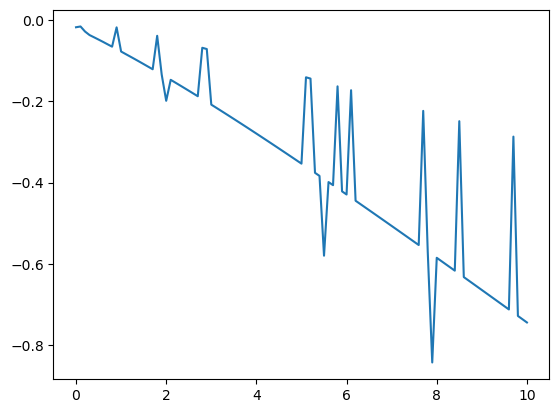

In [7]:
plt.plot(Xs, dev)

In [8]:
for f1, f2, f3 in list(zip(f_best_12, f_best_13, f_best_23)):
    np.min([f1, f2, f3])

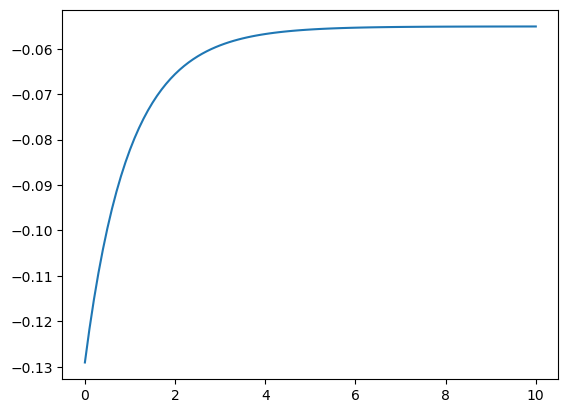

In [9]:
plt.plot(Xs, [np.min([f1, f2, f3]) for f1, f2, f3 in list(zip(f_best_12, f_best_13, f_best_23))])

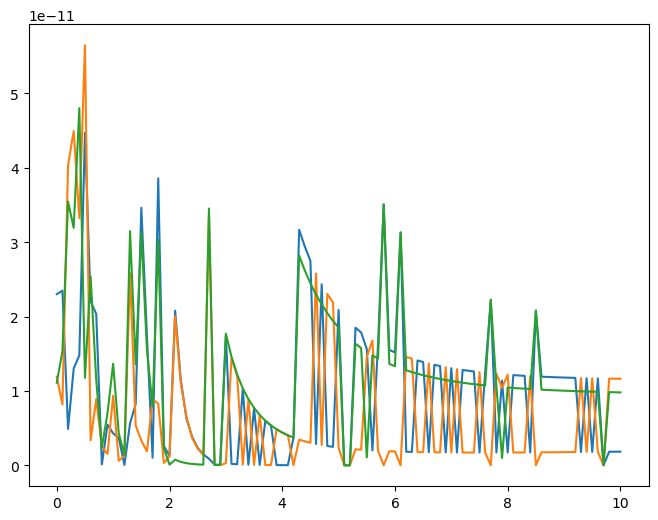

In [10]:
# plt.plot(Xs, np.abs(f_in))
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(Xs, [np.abs(f1-f2) for f1, f2 in list(zip(f_best_12,f_best_13))])
plt.plot(Xs, [np.abs(f1-f2) for f1, f2 in list(zip(f_best_13,f_best_23))])
plt.plot(Xs, [np.abs(f1-f2) for f1, f2 in list(zip(f_best_23,f_best_12))])
# plt.plot(Xs, np.abs(f_best_13))
# plt.plot(Xs, np.abs(f_best_23))
# plt.yscale("log")